**DESAFIO MURABEI** - Ciclo 01

<font size=15>**Candidato:** Ricardo Martini Kato</font>

# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as ss
from statsmodels.stats.diagnostic import lilliefors

import xgboost as xgb
import lightgbm as lgbm

from boruta import BorutaPy
from mrmr import mrmr_regression

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
D:\Anaconda\programa\envs\kaggle_challenge\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1. FUNCTIONS

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

def describe_num(num_attributes):
    a = num_attributes.describe().T.reset_index()
    
    d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T      
    d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(num_attributes.apply( lambda x: x.unique().shape[0])).T
    
    n = pd.concat([d4, d5, d6, d7], axis=0).T.reset_index()
    n.columns = ['attibutes', 'range', 'skew', 'kurtosis', 'unique']
    b = a.merge(n, right_on='attibutes', left_on='index')
    b.drop('index', axis=1, inplace=True)
    columns = ['attibutes', 'count', 'mean', 'std', '25%', '50%', '75%', 'min', 'max', 'range',
           'skew', 'kurtosis', 'unique']
    return b[columns]

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def cramer_v(x,y):
    cm = pd.crosstab(x, y).values #no curso ele usa a função .as_matrix() que foi descontinuada.
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    chi2corr =  max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (k-1)**2/(n-1)
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

def normal_test(normality_test):
    alpha = 0.05

    sf_t, k2_t, and_t, q2_t, lf_t, jb_t, ks_t = [[], [], [], [], [], [], []]
    name_columns = normality_test.columns

    for i in normality_test:
        if len(normality_test[i])<50:
            # Shapiro-Wilk Test - SAMPLE < 50
            statistic_wb, pvalue_wb = ss.shapiro(normality_test[i])        
            if pvalue_wb > alpha:
                sf_t = sf_t + ["H0 can be rejected - Prob. Gaussian"]
            else:
                sf_t = sf_t + ["H0 cannot be rejected - Prob. not Gaussian"]
        else:
            sf_t = sf_t + ['Test not possible']

        # D’Agostino’s K-squared test
        k2, p_k2 = ss.normaltest(normality_test[i])
        if p_k2 > alpha:
            k2_t = k2_t + ["H0 can be rejected - Prob. Gaussian"]
        else:
            k2_t = k2_t + ["H0 cannot be rejected - Prob. not Gaussian"]

        # Anderson-Darling Normality Test
        and_test = ss.anderson(normality_test[i], dist='norm')
        if and_test.statistic < and_test.critical_values[2]: #alpha = 0.05
            and_t = and_t + ["H0 can be rejected - Prob. Gaussian"]
        else:
            and_t = and_t + ["H0 cannot be rejected - Prob. not Gaussian"]

        # Chi-Square Normality Test
        statistic_q2, pvalue_q2 = ss.chisquare(normality_test[i])
        if pvalue_q2 > alpha:
            q2_t = q2_t + ["H0 can be rejected - Prob. Gaussian"]
        else:
            q2_t = q2_t + ["H0 cannot be rejected - Prob. not Gaussian"]

        # Lilliefors Test for Normality
        statistic_lillie, pvalue_lillie = lilliefors(normality_test[i])
        if pvalue_lillie > alpha:
            lf_t = lf_t + ["H0 can be rejected - Prob. Gaussian"]
        else:
            lf_t = lf_t + ["H0 cannot be rejected - Prob. not Gaussian"]

        #Jarque–Bera test for Normality (SAMPLES > 2000)
        if len(normality_test[i]) > 2000:
            statistic_jb, pvalue_jb = ss.jarque_bera(normality_test[i])
            alpha = 0.05
            if pvalue_jb > alpha:
                jb_t = jb_t + ["H0 can be rejected - Prob. Gaussian"]
            else:
                jb_t = jb_t + ["H0 cannot be rejected - Prob. not Gaussian"]
        else:
            jb_t = jb_t + ['Test not possible']

        # Kolmogorov-Smirnov test for Normality
        statistic_ks, pvalue_ks = ss.kstest(normality_test[i], 'norm')
        if pvalue_ks > alpha:
            ks_t = ks_t + ["H0 can be rejected - Prob. Gaussian"]
        else:
            ks_t = ks_t + ["H0 cannot be rejected - Prob. not Gaussian"]

    normal_t = pd.DataFrame([sf_t, k2_t, and_t, q2_t, lf_t, jb_t, ks_t], columns=name_columns).T
    normal_t.columns = ['Shapiro-Wilk Test', 'D’Agostino’s K-squared',
                    'Anderson-Darling', 'Chi-Square',
                    'Lilliefors', 'Jarque–Bera', 'Kolmogorov-Smirnov']
    
    return normal_t
        
pd.options.display.float_format = '{:.4f}'.format

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data
**-Variables Description**
* school - School ID
* schgend - School gender
* type - School type
* normexam - Normalized exam score
* schavg - School average of intake socre
* vr - Student level Verbal Reasoning (VR) socre band at intake
* intake - Band of student´s intake score
* standLRT - Standardised LR test score
* sex - Sex of the student - 'F' or 'M'
* Student - Student id (within school)


In [3]:
df_cat_sc = pd.read_csv('cat_school_data.csv', sep=';')
df_cat_st = pd.read_csv('cat_student_data.csv', sep=';')
df_num_sc = pd.read_csv('num_school_data.csv', sep=';')
df_num_st = pd.read_csv('num_student_data.csv', sep=';')

### 0.2.1 SCHOOL DATA

In [4]:
# Ajustando tabela Categorical School
aux1 = df_cat_sc.iloc[:65,:].copy().reset_index(drop=True).drop(columns='variable')
aux1.columns = ['school', 'schgend']
aux2 = df_cat_sc.iloc[65:,:].copy().reset_index(drop=True).drop(columns=['school','variable'])
aux2.columns = ['type']
df_cat_sc_adj = pd.concat([aux1, aux2], axis=1)

# ajustando a tabela - apenas 65 registro com uma única variável: shavg
df_num_sc = df_num_sc.rename(columns={'value': 'schavg'}).drop(columns='variable')

# Juntando tabelas School
df_school = pd.merge(df_cat_sc_adj, df_num_sc, on='school', how='left')

In [5]:
df_school.head()

,school,schgend,type,schavg
0,1,mixed,Mxd,"0,1661752"
1,2,girls,Sngl,"0,3951492"
2,3,mixed,Mxd,"0,5141552"
3,4,mixed,Mxd,"0,0917642"
4,5,mixed,Mxd,"0,2105252"


### 0.2.2 STUDENT DATA

In [6]:
# Ajustando tabela Categorical Student
df_cat_st['school'] = df_cat_st['school'].astype('str')
df_cat_st['student'] = df_cat_st['student'].astype('str')
df_cat_st['sc_st'] = df_cat_st['school'] + '_' + df_cat_st['student']
df_cat_st = df_cat_st.drop(columns=['student'])

# Criando tabela única para a variável 'intake'
df_cat_intake = df_cat_st[df_cat_st['variable'] == 'intake'].copy()
df_cat_intake = df_cat_intake.rename(columns={'value': 'intake'})
df_cat_intake = df_cat_intake.drop(columns=['variable'])

# Criando tabela única para a variável 'vr'
df_cat_vr = df_cat_st[df_cat_st['variable'] == 'vr'].copy()
df_cat_vr = df_cat_vr.rename(columns={'value': 'vr'})
df_cat_vr = df_cat_vr.drop(columns=['variable', 'school'])

# Criando tabela única para a variável 'sex'
df_cat_sex = df_cat_st[df_cat_st['variable'] == 'sex'].copy()
df_cat_sex = df_cat_sex.rename(columns={'value': 'sex'})
df_cat_sex = df_cat_sex.drop(columns=['variable', 'school'])

# Centralizando as tabelas por variável
df_cat_st_adj = pd.merge(df_cat_intake, df_cat_vr, on='sc_st', how='left')
df_cat_st_adj = pd.merge(df_cat_st_adj, df_cat_sex, on='sc_st', how='left')
df_cat_st_adj = df_cat_st_adj.drop(columns='school')

In [7]:
# Verificando se os valores NA correspondem a mesma escola para as duas situações
# CONCLUSÃO: Há um match entre as escolas, e de forma a não perder os registros será alocado como Estudante 999 na tabela
#aux = df_num_st[df_num_st['student'].isna()].copy()
#aux_normexam = aux[aux['variable'] == 'normexam']
#aux_standLRT = aux[aux['variable'] == 'standLRT']
#aux_num_st_na = pd.merge(aux_normexam, aux_standLRT, on='school', how='left')

# Ajustando tabela Numerical Student
# Ajustando tabela do estudante ausente como 999
df_num_st['student'] = df_num_st['student'].apply(lambda x: 999 if pd.isnull(x) else x)

# Criando variável school + student
df_num_st['student'] = df_num_st['student'].astype('int')
df_num_st['student'] = df_num_st['student'].astype('str')
df_num_st['school'] = df_num_st['school'].astype('str')
df_num_st['sc_st'] = df_num_st['school'] + '_' + df_num_st['student']
df_num_st = df_num_st.drop(columns='student')

# Separando as variáveis 'normexam' e 'standLRT'
df_num_normexam = df_num_st[df_num_st['variable']=='normexam'].copy()
df_num_normexam = df_num_normexam.rename(columns={'value': 'normexam'}).drop(columns='variable')
df_num_standLRT = df_num_st[df_num_st['variable']=='standLRT'].copy()
df_num_standLRT = df_num_standLRT.rename(columns={'value': 'standLRT'}).drop(columns=['variable', 'school'])

# Juntando as variáveis numéricas student
df_num_st_adj = pd.merge(df_num_normexam, df_num_standLRT, on='sc_st', how='left')

# Juntando tabelas Student
df_student = pd.merge(df_num_st_adj, df_cat_st_adj, on='sc_st', how='left')

### 0.2.3 FINAL DATAFRAME

In [8]:
df_student['school'] = df_student['school'].astype('int')
df_raw = pd.merge(df_student, df_school, on='school', how='left')

In [9]:
df_raw.head()

,school,normexam,sc_st,standLRT,intake,vr,sex,schgend,type,schavg
0,1,"0,2613242",1_143,"0,6190592",bottom 25%,mid 50%,F,mixed,Mxd,"0,1661752"
1,1,"0,1340672",1_145,"0,2058022",mid 50%,mid 50%,F,mixed,Mxd,"0,1661752"
2,1,"-1,723882",1_142,"-1,364576",top 25%,mid 50%,M,mixed,Mxd,"0,1661752"
3,1,"0,9675862",1_141,"0,2058022",mid 50%,mid 50%,F,mixed,Mxd,"0,1661752"
4,1,"0,5443412",1_138,"0,3711052",mid 50%,mid 50%,F,mixed,Mxd,"0,1661752"


# 1.0 DATA DESCRIPTION

In [10]:
df1 = df_raw.copy()

## 1.1 Rename Colums

In [11]:
df1.columns

Index(['school', 'normexam', 'sc_st', 'standLRT', 'intake', 'vr', 'sex',
       'schgend', 'type', 'schavg'],
      dtype='object')

## 1.2 Data Dimensions

In [12]:
print('Number of Rows: {}'.format (df1.shape[0]))
print('Number of Rows: {}'.format (df1.shape[1]))

Number of Rows: 4213
Number of Rows: 10


## 1.3 Data Types

In [13]:
df1.dtypes

school       int32
normexam    object
sc_st       object
standLRT    object
intake      object
vr          object
sex         object
schgend     object
type        object
schavg      object
dtype: object

## 1.4 Check NA

In [14]:
df_na = pd.DataFrame(df1.isna().sum(), columns=['NA'])
df_na['%'] = round(df_na['NA']/len(df1)*100, 2)
df_na

,NA,%
school,0,0.0000
normexam,88,2.0900
sc_st,0,0.0000
standLRT,29,0.6900
intake,146,3.4700
vr,198,4.7000
sex,240,5.7000
schgend,0,0.0000
type,0,0.0000
schavg,0,0.0000


In [15]:
df1[df1['normexam'].isna()]

,school,normexam,sc_st,standLRT,intake,vr,sex,schgend,type,schavg
21,1,NaN,1_220,"-1,364576",top 25%,mid 50%,M,mixed,Mxd,"0,1661752"
53,1,NaN,1_84,"0,3711052",bottom 25%,mid 50%,F,mixed,Mxd,"0,1661752"
173,3,NaN,3_64,"-0,868667",mid 50%,top 25%,M,mixed,Mxd,"0,5141552"
260,5,NaN,5_166,"0,2058022",mid 50%,top 25%,M,mixed,Mxd,"0,2105252"
413,7,NaN,7_180,"-0,124804",NaN,NaN,NaN,girls,Sngl,"-0,029003"
439,7,NaN,7_16,"-0,786016",mid 50%,mid 50%,F,girls,Sngl,"-0,029003"
458,7,NaN,7_76,"-0,042152",mid 50%,mid 50%,F,girls,Sngl,"-0,029003"
550,8,NaN,8_73,"1,0323172",bottom 25%,mid 50%,F,girls,Sngl,"-0,040532"
580,9,NaN,9_147,"-0,290107",mid 50%,bottom 25%,M,mixed,Mxd,"-0,494304"
725,12,NaN,12_91,"-0,951318",mid 50%,mid 50%,M,mixed,Mxd,"-0,00874"


## 1.5 Fillout NA

In [16]:
# Será removido os NA neste ciclo, caso verifique alguma significância no modelo poderá ser avaliado uma forma de substituição
df1_ = df1.copy()
df1_ = df1_.dropna(subset=['normexam', 'standLRT', 'intake', 'vr'])
df1_ = df1_.drop(columns='sex') #remover sex no qual não há relevância para o modelo (essa variável já é explicado por schgend)
df1_.shape

(3904, 9)

## 1.6 Change Types

In [17]:
df1_.dtypes

school       int32
normexam    object
sc_st       object
standLRT    object
intake      object
vr          object
schgend     object
type        object
schavg      object
dtype: object

In [18]:
df1_['normexam'] = df1_['normexam'].apply(lambda x: x.replace(',', '.'))
df1_['standLRT'] = df1_['standLRT'].apply(lambda x: x.replace(',', '.'))
df1_['schavg'] = df1_['schavg'].apply(lambda x: x.replace(',', '.'))

numerical = ['normexam', 'standLRT', 'schavg']
df1_[numerical] = df1_[numerical].astype('float64')

In [19]:
df1_.head()

,school,normexam,sc_st,standLRT,intake,vr,schgend,type,schavg
0,1,0.2613,1_143,0.6191,bottom 25%,mid 50%,mixed,Mxd,0.1662
1,1,0.1341,1_145,0.2058,mid 50%,mid 50%,mixed,Mxd,0.1662
2,1,-1.7239,1_142,-1.3646,top 25%,mid 50%,mixed,Mxd,0.1662
3,1,0.9676,1_141,0.2058,mid 50%,mid 50%,mixed,Mxd,0.1662
4,1,0.5443,1_138,0.3711,mid 50%,mid 50%,mixed,Mxd,0.1662


## 1.7 Descriptive Statistical

In [20]:
num_attributes = df1_.select_dtypes(include=('int64', 'float64'))
cat_attributes = df1_.select_dtypes(exclude=('int64', 'float64', 'datetime64[ns]'))

<AxesSubplot:>

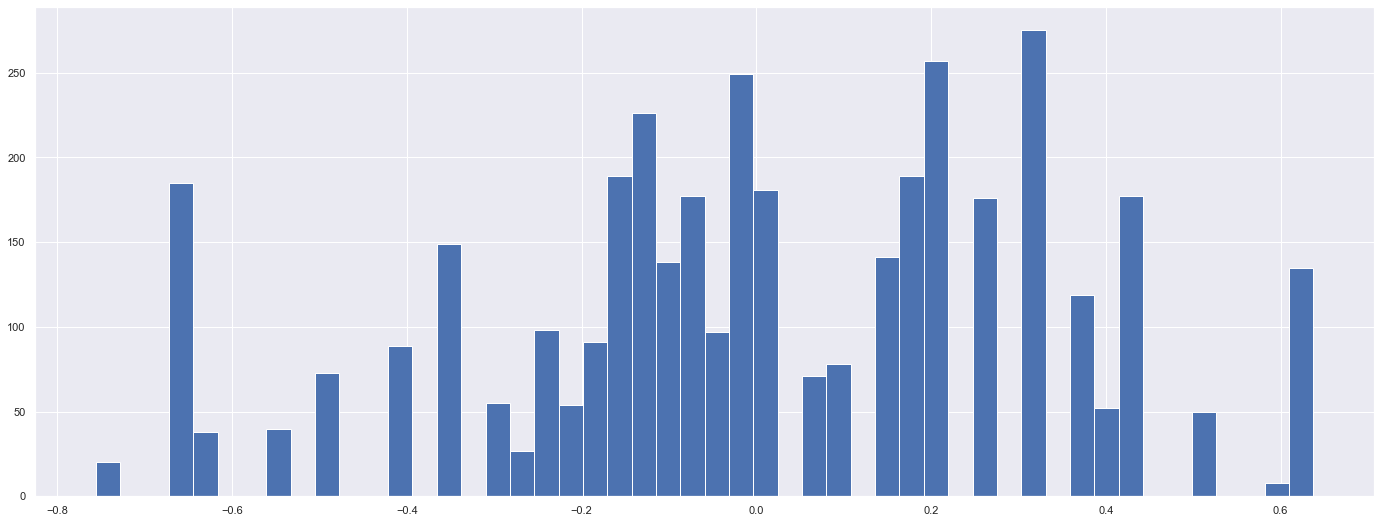

In [21]:
num_attributes['schavg'].hist(bins=50)

### 1.7.1 Numerical Attibutes

In [22]:
describe_num(num_attributes)

,attibutes,count,mean,std,25%,50%,75%,min,max,range,skew,kurtosis,unique
0,normexam,3904.0000,-0.0067,1.0111,-0.6995,0.0043,0.6788,-3.6661,3.6661,7.3322,0.0186,-0.0368,71.0000
1,standLRT,3904.0000,0.0068,0.9907,-0.6207,0.0405,0.6191,-2.9350,3.0160,5.9509,-0.1069,0.0681,70.0000
2,schavg,3904.0000,0.0111,0.3149,-0.1493,-0.0131,0.2674,-0.7560,0.6377,1.3936,-0.2579,-0.3294,65.0000


* 'normexam' - O interval das notas é entre -3.6661 a 3.6661. A mediana é 0.0043 e a média -0.0067 o que indica um skew positivo bem baixo (0.0186) e uma curva achatada (kurtosis negativa)
* 'standLRT' - O interval das notas é entre -2.9350 a 3.0160. A mediana é 0.6191 e a média 0.0068 o que indica um skew negativo baixo (-0.1069) e uma curva com tendência acentuada (kurtosis positiva)
* 'schavg' - O interval das notas é entre -0.7560 a 0.6377. A mediana é -0.0131 e a média 0.0111 o que indica um skew negativo mais acentuado (-0.2579) e uma curva achatada (kurtosis negativa)

### 1.7.2 Categorical Attibutes

In [23]:
cat_attributes.apply( lambda x: x.unique().shape[0])

school       65
sc_st      3796
intake        3
vr            3
schgend       3
type          2
dtype: int64

* 'school' - total de 65 escolas cadastradas
* 'sc_st' - 3796 estudantes cadastrados nas 65 escolas
* 'intake' - possui 3 categorias: 'bottom 25%', 'mid 50%', 'top 25%'
* 'vr' - possui 3 categorias: 'bottom 25%', 'mid 50%', 'top 25%'
* 'schgend' - possui 3 categorias: 'mixed', 'girls', 'boys'
* 'type' - possui 3 categorias: 'Mxd', 'Sngl'

# 2.0 FEATURE ENGINEERING

In [24]:
# Não há muito contexto sobre as variáveis e desta maneira não será feito feature engineering
df2 = df1_.copy()
df2.head()

,school,normexam,sc_st,standLRT,intake,vr,schgend,type,schavg
0,1,0.2613,1_143,0.6191,bottom 25%,mid 50%,mixed,Mxd,0.1662
1,1,0.1341,1_145,0.2058,mid 50%,mid 50%,mixed,Mxd,0.1662
2,1,-1.7239,1_142,-1.3646,top 25%,mid 50%,mixed,Mxd,0.1662
3,1,0.9676,1_141,0.2058,mid 50%,mid 50%,mixed,Mxd,0.1662
4,1,0.5443,1_138,0.3711,mid 50%,mid 50%,mixed,Mxd,0.1662


# 3.0 FEATURE FILTERING

In [25]:
df3 = df2.copy()
df3.head()

,school,normexam,sc_st,standLRT,intake,vr,schgend,type,schavg
0,1,0.2613,1_143,0.6191,bottom 25%,mid 50%,mixed,Mxd,0.1662
1,1,0.1341,1_145,0.2058,mid 50%,mid 50%,mixed,Mxd,0.1662
2,1,-1.7239,1_142,-1.3646,top 25%,mid 50%,mixed,Mxd,0.1662
3,1,0.9676,1_141,0.2058,mid 50%,mid 50%,mixed,Mxd,0.1662
4,1,0.5443,1_138,0.3711,mid 50%,mid 50%,mixed,Mxd,0.1662


In [26]:
# Columns
# 'Type' - Apenas representa se é mxd ou sngl no qual fica acaba representando o mesmo que 'schgend'
df3 = df3.drop(columns='type')

# 4.0 EXPLORATORY DATA ANALYSIS

In [27]:
df4 = df3.copy()
df4.head()

,school,normexam,sc_st,standLRT,intake,vr,schgend,schavg
0,1,0.2613,1_143,0.6191,bottom 25%,mid 50%,mixed,0.1662
1,1,0.1341,1_145,0.2058,mid 50%,mid 50%,mixed,0.1662
2,1,-1.7239,1_142,-1.3646,top 25%,mid 50%,mixed,0.1662
3,1,0.9676,1_141,0.2058,mid 50%,mid 50%,mixed,0.1662
4,1,0.5443,1_138,0.3711,mid 50%,mid 50%,mixed,0.1662


In [28]:
num_attributes = df4.select_dtypes(include=('int64', 'float64'))
cat_attributes = df4.select_dtypes(exclude=('int64', 'float64', 'datetime64[ns]'))

## 4.1. UNIVARIABLE ANALYSIS

### 4.1.1. RESPONSE VARIABLE

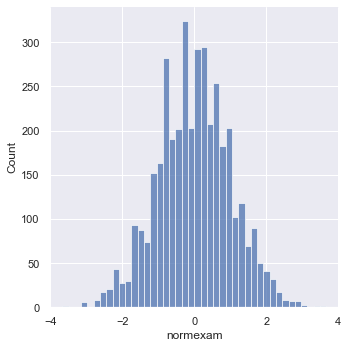

In [29]:
sns.displot(df4['normexam'])

### 4.1.2. NUMERICAL VARIABLE

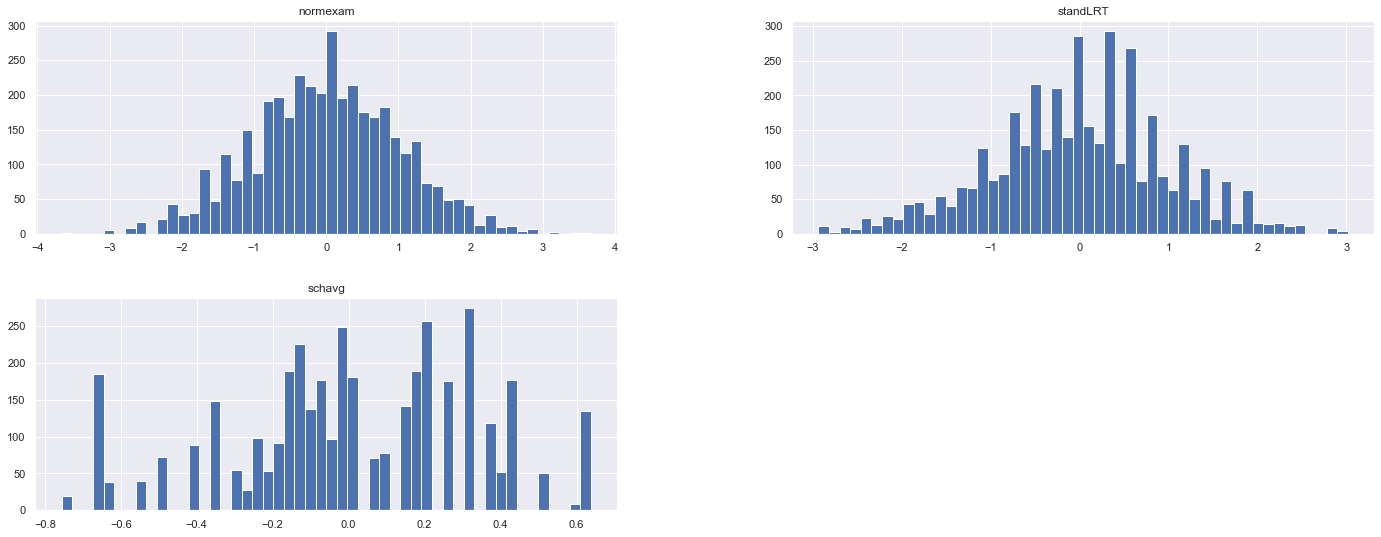

In [30]:
num_attributes.hist(bins=50);

### 4.1.3. CATEGORICAL VARIABLE

In [31]:
cat_attributes.columns

Index(['school', 'sc_st', 'intake', 'vr', 'schgend'], dtype='object')

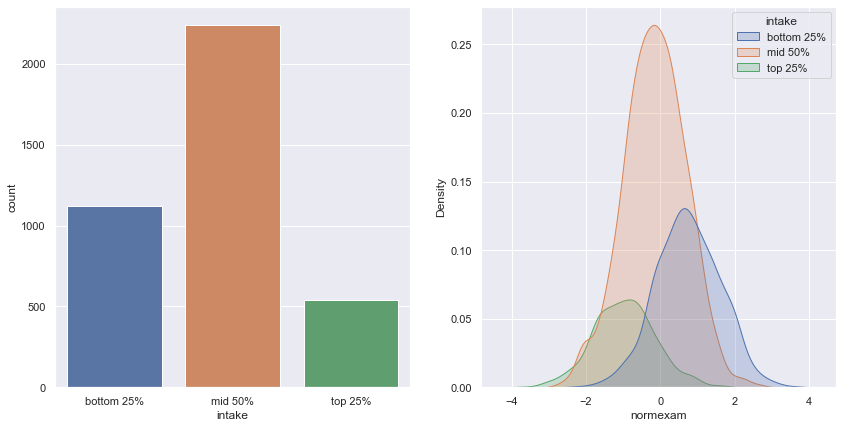

In [32]:
#intake
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.countplot(data=df4, x='intake')

plt.subplot(1, 2, 2)
sns.kdeplot(data=df4, x='normexam', hue='intake', shade=True);

# COMENTARIO: Há uma inversão, no qual aqueles que possuem intake abaixo de 25% possuem normexam médio mais altos daqueles que obtiveram intake no top 25%. 
# Aqueles enquadrados no mid 50% possuem uma distribuição centralizada (aparentemente normal) no normexam

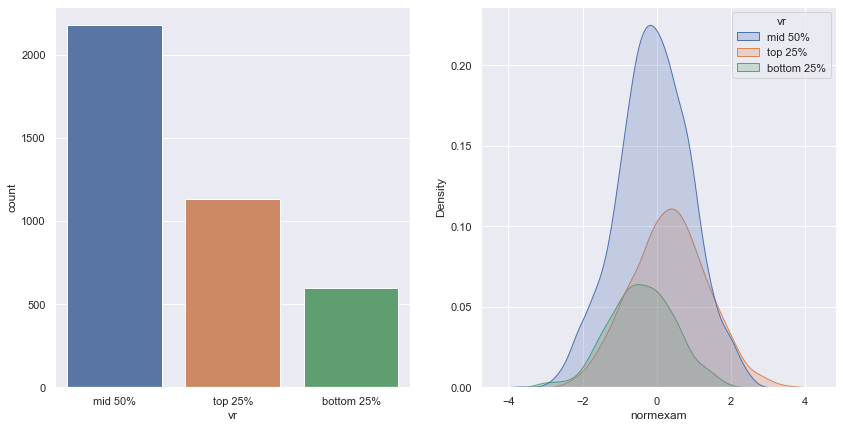

In [33]:
#vr
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.countplot(data=df4, x='vr')

plt.subplot(1, 2, 2)
sns.kdeplot(data=df4, x='normexam', hue='vr', shade=True);

# COMENTÁRIO: vr na faixa top25% possui notas maiores em média no normexam e oposto ocorre com o botton25% porém não muito distante.

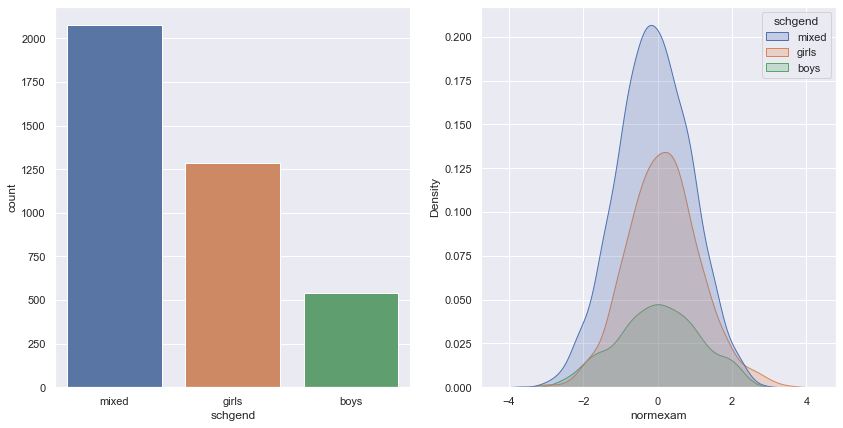

In [34]:
#schgend
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.countplot(data=df4, x='schgend')

plt.subplot(1, 2, 2)
sns.kdeplot(data=df4, x='normexam', hue='schgend', shade=True);

# COMENTÁRIO: há uma aparente centralização das notas normexam para a variável schgend sem uma evidência nítida para o tipo de gênero da escola. Entretanto, escolas de meninas possuem um desempenho medio melhor.

In [135]:
df4[['normexam', 'schgend']].groupby('schgend').mean()

,normexam
schgend,
boys,0.0112
girls,0.1486
mixed,-0.1074


## 4.2. BIVARIABLE ANALYSIS

In [35]:
df4.head()

,school,normexam,sc_st,standLRT,intake,vr,schgend,schavg
0,1,0.2613,1_143,0.6191,bottom 25%,mid 50%,mixed,0.1662
1,1,0.1341,1_145,0.2058,mid 50%,mid 50%,mixed,0.1662
2,1,-1.7239,1_142,-1.3646,top 25%,mid 50%,mixed,0.1662
3,1,0.9676,1_141,0.2058,mid 50%,mid 50%,mixed,0.1662
4,1,0.5443,1_138,0.3711,mid 50%,mid 50%,mixed,0.1662


### normexam vs stndLRT

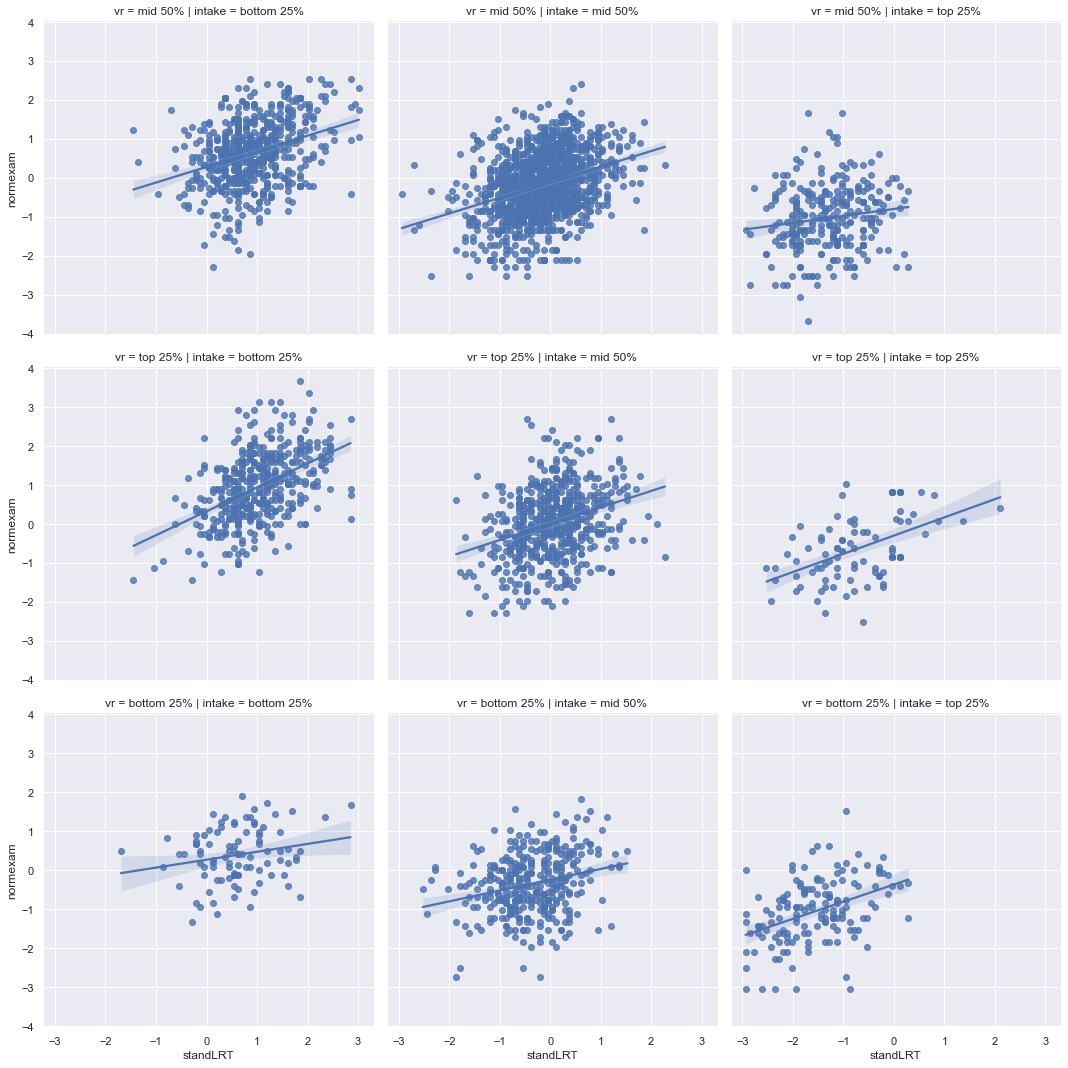

In [36]:
sns.lmplot(x="standLRT", y="normexam", data=df4, col='intake', row='vr');
# COMENTÀRIO: Há uma grande dispersão para cada uma das faixas, mesmo dividindo os dados pelas categóricas intake e vr.
# Vale ressaltar que todas as relações são positivas

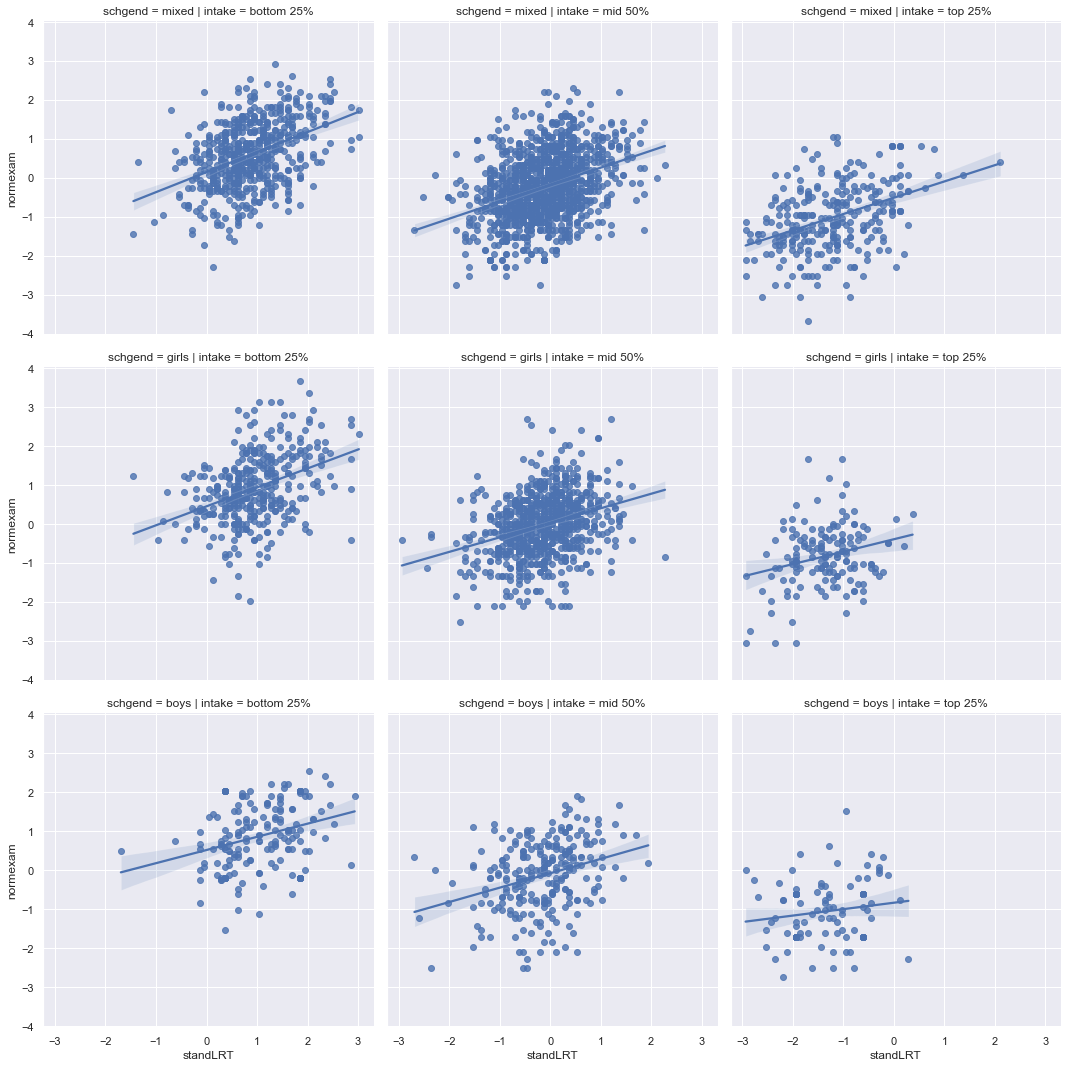

In [37]:
sns.lmplot(x="standLRT", y="normexam", data=df4, col='intake', row='schgend');
# COMENTARIO: incluindo a variável schgend junto com a intake não há uma mudança significativa na tendência do gráfico.

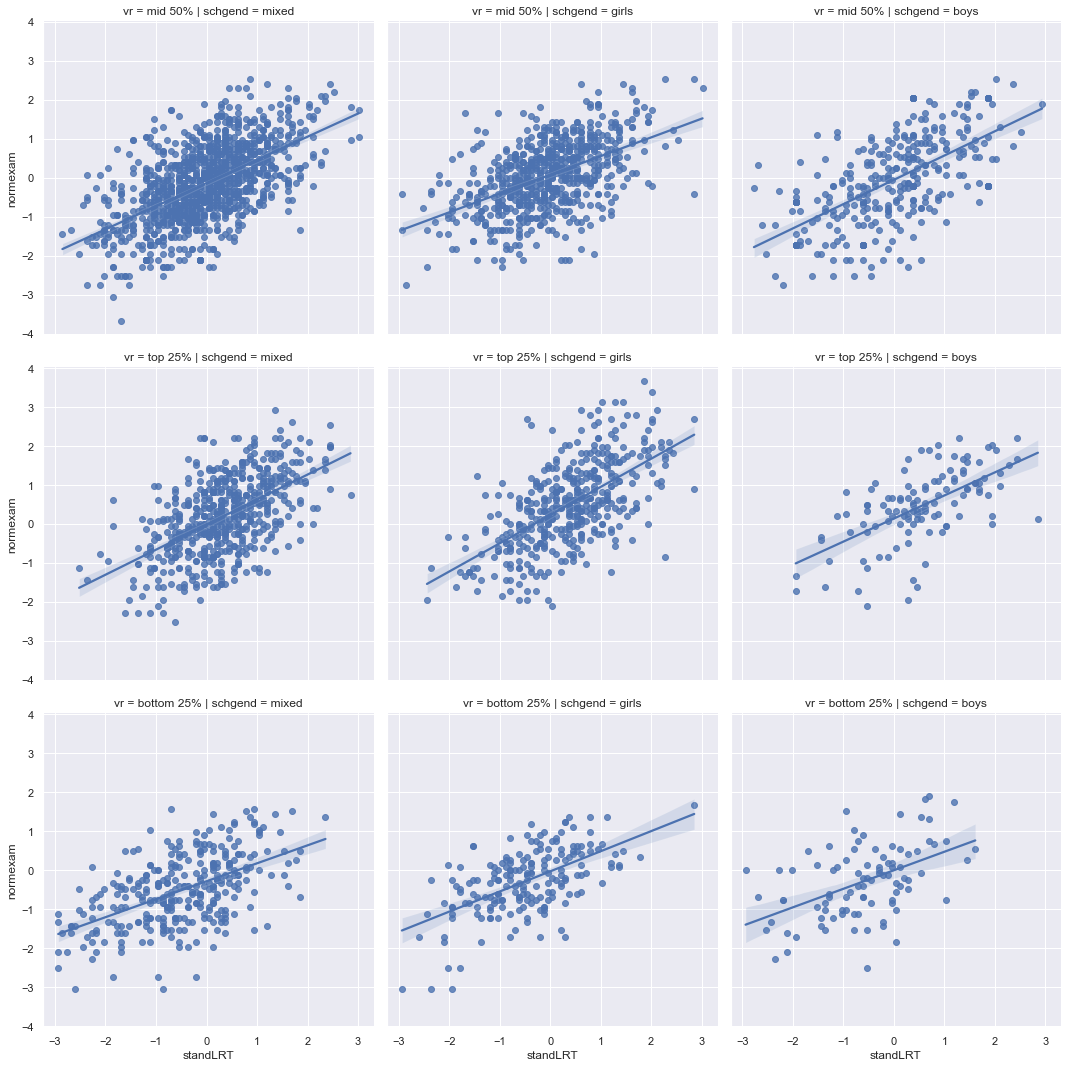

In [38]:
sns.lmplot(x="standLRT", y="normexam", data=df4, col='schgend', row='vr');

### normexam vs schavg

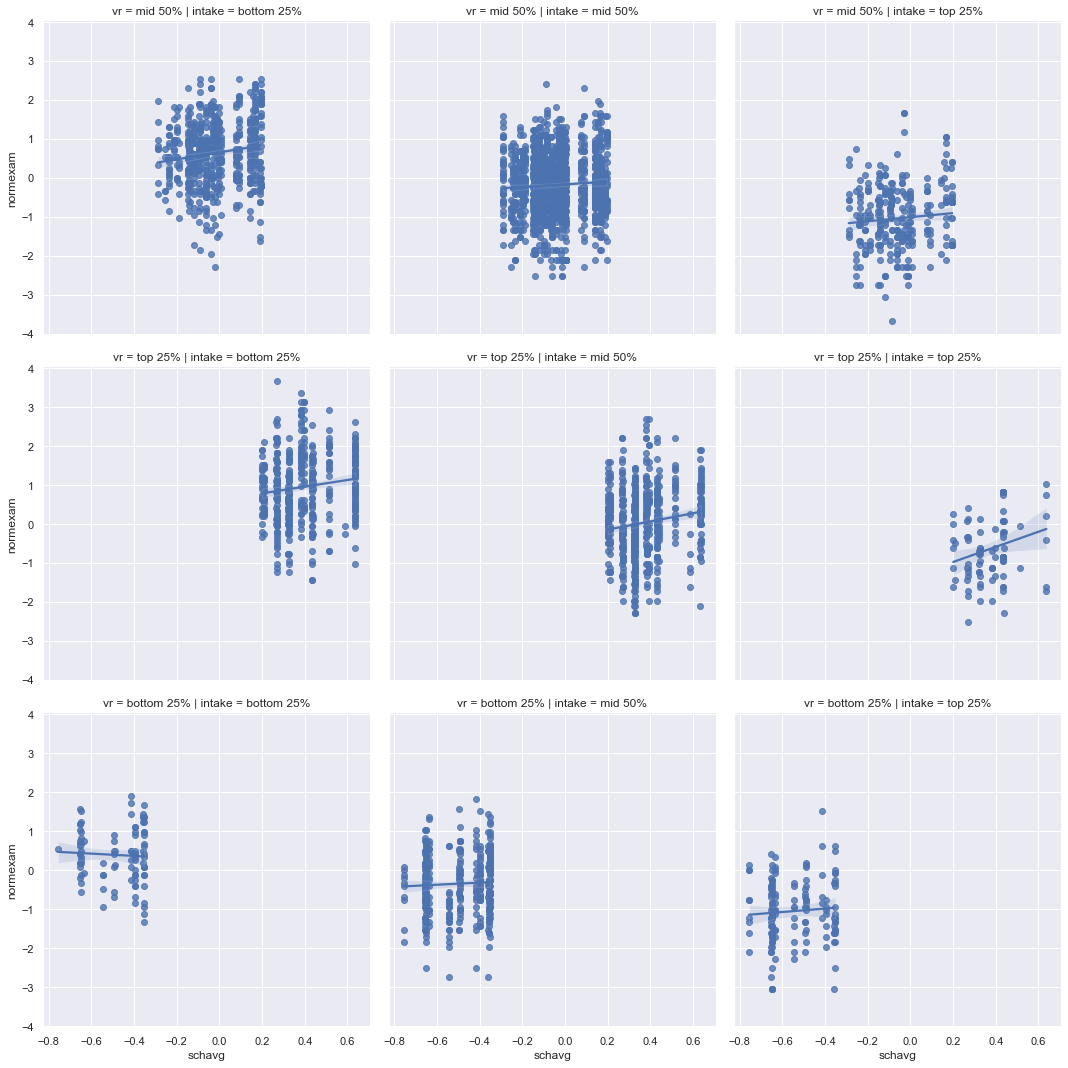

In [39]:
# normexam vs schavg
sns.lmplot(x="schavg", y="normexam", data=df4, col='intake', row='vr');
# COMENTÀRIO: Há uma grande dispersão para cada uma das faixas, mesmo dividindo os dados pelas categóricas intake e vr.
# Importante mencionar que a unica relação negativa occore no vr e intake com bottom25% indicando uma tendência de queda das notas.

## 4.3. MULTIVARIABLE ANALYSIS

### 4.3.1. NUMERICAL ATTIBUTES

<AxesSubplot:>

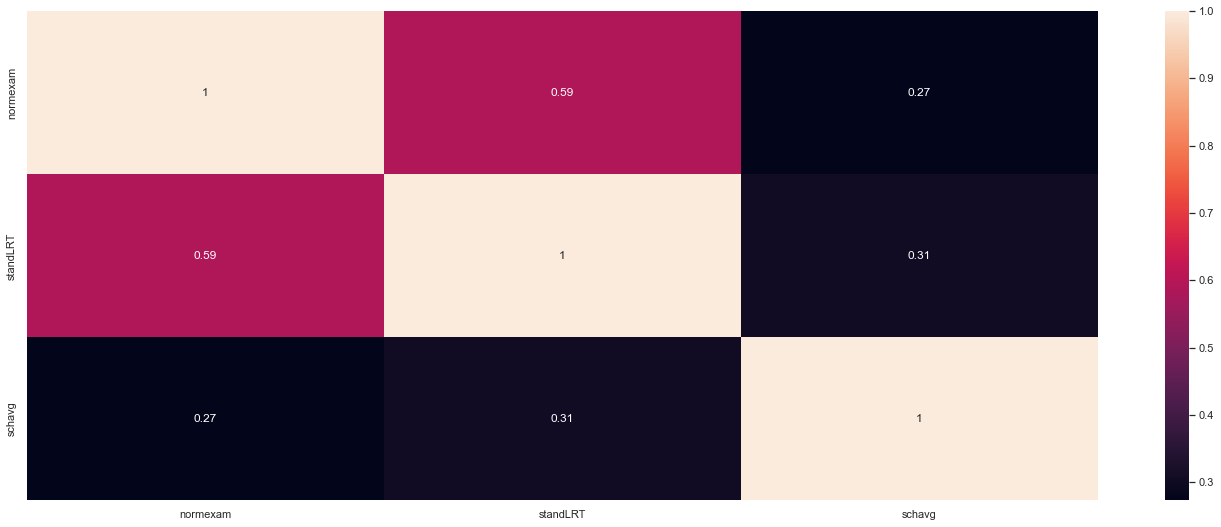

In [40]:
correlation = num_attributes.corr(method ='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2. CATEGORICAL ATTRIBUTES

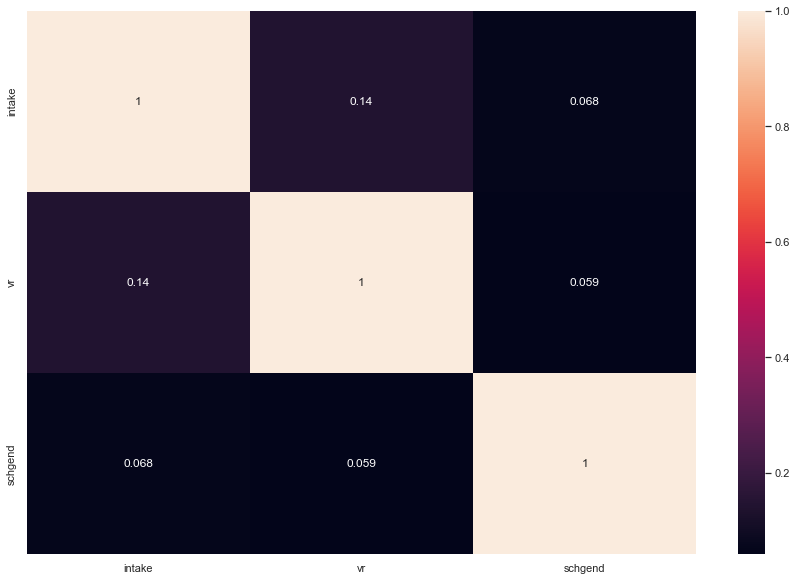

In [41]:
a = df4[['intake', 'vr', 'schgend']].copy()#.select_dtypes(include='object')
nivel = a.shape[1]
a_d = a.columns.tolist()
a_e = a.columns.tolist()

crm_l = []
for i in range(nivel):
    crm = []
    for j in range(nivel):
        crm.append(cramer_v(a[a_d[i]], a[a_e[j]]))
    crm_l.append(crm)
    
d = pd.DataFrame(crm_l)
d.columns = a_d

d = d.set_index(d.columns)
plt.figure(figsize=(15, 10))
sns.heatmap(d, annot=True)
plt.show()

# 5.0 DATA PREPARATION

In [42]:
df5 = df4.copy()
df5.head()

,school,normexam,sc_st,standLRT,intake,vr,schgend,schavg
0,1,0.2613,1_143,0.6191,bottom 25%,mid 50%,mixed,0.1662
1,1,0.1341,1_145,0.2058,mid 50%,mid 50%,mixed,0.1662
2,1,-1.7239,1_142,-1.3646,top 25%,mid 50%,mixed,0.1662
3,1,0.9676,1_141,0.2058,mid 50%,mid 50%,mixed,0.1662
4,1,0.5443,1_138,0.3711,mid 50%,mid 50%,mixed,0.1662


In [43]:
df5_ = df5.copy()
num_attributes = df5_.select_dtypes(include=('int64', 'float64'))
cat_attributes = df5_.select_dtypes(exclude=('int64', 'float64', 'datetime64[ns]'))

In [44]:
# Verificando normalidade dos dados (numéricos)
normal_test(num_attributes)

,Shapiro-Wilk Test,D’Agostino’s K-squared,Anderson-Darling,Chi-Square,Lilliefors,Jarque–Bera,Kolmogorov-Smirnov
normexam,Test not possible,H0 can be rejected - Prob. Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 can be rejected - Prob. Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 can be rejected - Prob. Gaussian,H0 can be rejected - Prob. Gaussian
standLRT,Test not possible,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian
schavg,Test not possible,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian


In [45]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
normexam,3904.0000,-0.0067,1.0111,-3.6661,-0.6995,0.0043,0.6788,3.6661
standLRT,3904.0000,0.0068,0.9907,-2.9350,-0.6207,0.0405,0.6191,3.0160
schavg,3904.0000,0.0111,0.3149,-0.7560,-0.1493,-0.0131,0.2674,0.6377


In [46]:
# NUMERICAL VALUES
mms = MinMaxScaler()
mms_columns = ['standLRT', 'schavg']             

#Min-Max Scaler
df5_[mms_columns] = mms.fit_transform(df5_[mms_columns])

In [47]:
cat_attributes.head()

,school,sc_st,intake,vr,schgend
0,1,1_143,bottom 25%,mid 50%,mixed
1,1,1_145,mid 50%,mid 50%,mixed
2,1,1_142,top 25%,mid 50%,mixed
3,1,1_141,mid 50%,mid 50%,mixed
4,1,1_138,mid 50%,mid 50%,mixed


In [48]:
cat_attributes['schgend'].unique()

array(['mixed', 'girls', 'boys'], dtype=object)

In [49]:
encoder_intake_vr = {'bottom 25%': 1, 'mid 50%': 2, 'top 25%': 3}

# CATEGORICAL VALUES
#intake - Ordinal Encoding
df5_['intake'] = df5_['intake'].map(encoder_intake_vr)

#vr - Ordinal Encoding
df5_['vr'] = df5_['vr'].map(encoder_intake_vr)

#schgend - OHE
df5_ = pd.get_dummies(df5_, prefix=['schgend'], columns=['schgend'])

In [50]:
# RESPONSE VARIABLE TRANSFORMATION
# tendo em vista que no teste de normalidade normexam é indicado como prov normal, não será realizado ajuste.

In [51]:
df5_.head()

,school,normexam,sc_st,standLRT,intake,vr,schavg,schgend_boys,schgend_girls,schgend_mixed
0,1,0.2613,1_143,0.5972,1,2,0.6617,0,0,1
1,1,0.1341,1_145,0.5278,2,2,0.6617,0,0,1
2,1,-1.7239,1_142,0.2639,3,2,0.6617,0,0,1
3,1,0.9676,1_141,0.5278,2,2,0.6617,0,0,1
4,1,0.5443,1_138,0.5556,2,2,0.6617,0,0,1


# 6.0 FEATURE SELECTION

In [52]:
df6 = df5_.copy()
df6.head()

,school,normexam,sc_st,standLRT,intake,vr,schavg,schgend_boys,schgend_girls,schgend_mixed
0,1,0.2613,1_143,0.5972,1,2,0.6617,0,0,1
1,1,0.1341,1_145,0.5278,2,2,0.6617,0,0,1
2,1,-1.7239,1_142,0.2639,3,2,0.6617,0,0,1
3,1,0.9676,1_141,0.5278,2,2,0.6617,0,0,1
4,1,0.5443,1_138,0.5556,2,2,0.6617,0,0,1


In [53]:
X = df6.drop(['normexam'], axis=1 )
y = df6['normexam'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2928, 9) (2928,)
(976, 9) (976,)


## 6.1. BORUTA AS FEATURE SELECTOR

In [54]:
#training and test dataset for Boruta
X_train_n = X_train.drop(columns=['school', 'sc_st']).values
y_train_n = y_train.values #ravel coverter em vetor

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	5


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	5


#### 6.2.1.1 BEST FEATURES FROM BORUTA

In [55]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(columns=['school', 'sc_st'])
sf_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

sf_boruta

['standLRT', 'schavg']

## 6.2 EXTRA TREE - Regressor

In [56]:
#model definition
forest = ExtraTreesRegressor(n_estimators=250, random_state=0, n_jobs=-1)

x_train_n = X_train.drop(columns=['school', 'sc_st'])
y_train_n = y_train.values

forest.fit(x_train_n, y_train_n)

ExtraTreesRegressor(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking: 
         feature  importance  acumulative
0       standLRT      0.3752       0.3752
0         intake      0.2867       0.6619
0         schavg      0.2669       0.9289
0             vr      0.0289       0.9577
0  schgend_mixed      0.0181       0.9758
0  schgend_girls      0.0145       0.9903
0   schgend_boys      0.0097       1.0000


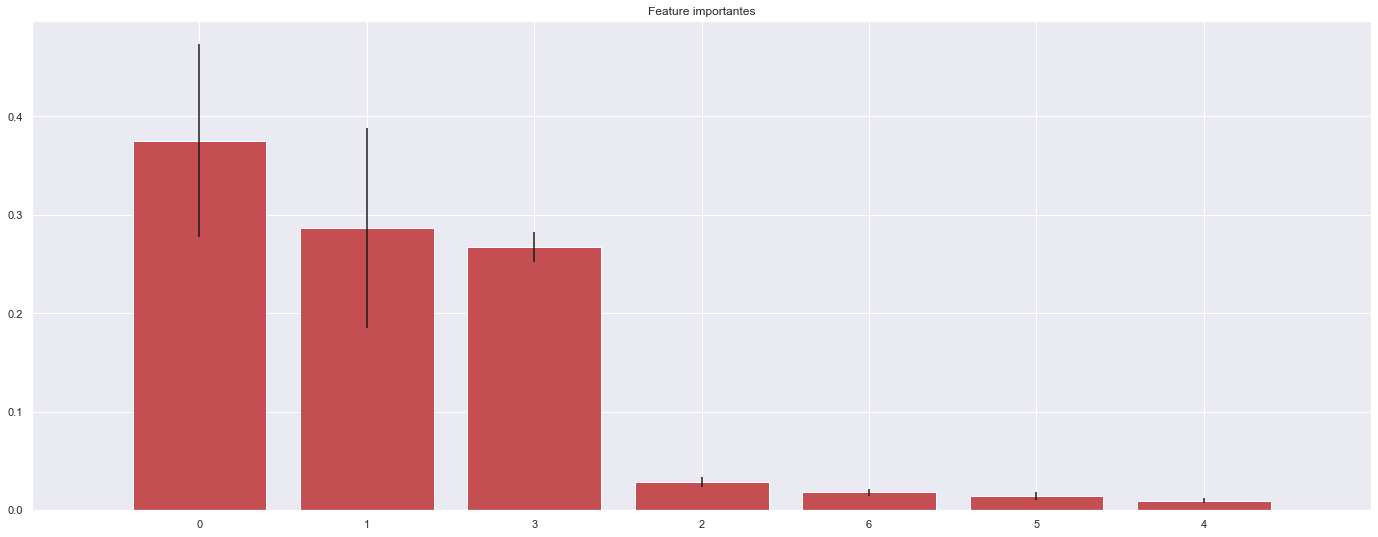

In [57]:
importances = forest.feature_importances_ #get the values of features
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0) #take the std from the feature selector
indices = np.argsort(importances)[::-1] #organize the indice by descendent

# Print the feature ranking
print("Feature ranking: ")
df = pd.DataFrame()
for i, j in zip(x_train_n.columns.values, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    df = df.sort_values('importance', ascending=False)
    df['acumulative'] = df['importance'].cumsum()
    
print (df)

# Plot the impurity-bases feature importances of the forest
plt.figure()
plt.title('Feature importantes')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r',
        yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

In [58]:
sf_et = ['standLRT', 'intake', 'schavg 25%', 'vr']

## 6.3 XGBoost - Regressor

In [59]:
#model definition
xgb_model = xgb.XGBRegressor()

x_train_n = X_train.drop(columns=['school', 'sc_st'])
y_train_n = y_train.values

xgb_model.fit(x_train_n, y_train_n)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

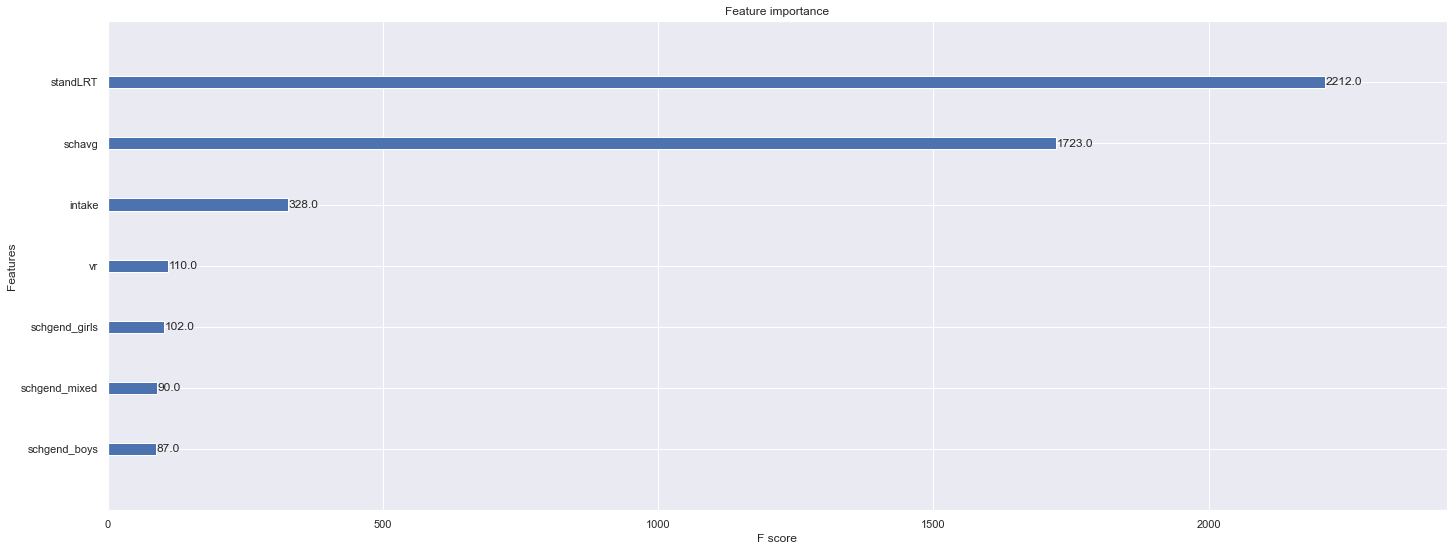

In [60]:
xgb.plot_importance(xgb_model)

In [61]:
sf_xgb = ['standLRT', 'schavg', 'intake']

## 6.4 mRMR - Regressor

In [62]:
sf_mRMR = mrmr_regression(X=X_train.drop(columns=['school', 'sc_st']), y=y_train, K=5)
sf_mRMR

100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


['standLRT', 'schgend_girls', 'intake', 'schavg', 'vr']

# 7.0 MACHINE LEARNING MODELLING

In [104]:
sf_boruta = ['standLRT', 'schavg']
sf_et = ['standLRT', 'schavg', 'intake']
sf_xgb = ['standLRT', 'schavg', 'intake']
sf_mRMR = ['standLRT', 'schgend_girls', 'intake', 'schavg', 'vr']

final_features = sf_boruta.copy()

In [120]:
x_train = X_train[final_features]
x_test = X_val[final_features]

feat_to_add = ['normexam']
final_features_full = final_features.copy()
final_features_full.extend(feat_to_add)
x_training = df6[final_features_full]

In [121]:
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat)/y)

def ml_error(model_name, y, yhat):
    Y = pd.DataFrame([y]).T.copy()
    Y.columns = ['normexam']
    P = pd.DataFrame([yhat]).T.copy().rename(columns={0:'prediction'})
    T = pd.concat([Y, P], axis=1)
    T['diff'] = abs(T['normexam'] - T['prediction'])
    T['div'] = T['normexam'].apply(lambda x: 1 if x == 0 else x)
    T['mape_p'] = T['diff']/T['div']
    mape = T['mape_p'].sum()/T.shape[0]
    
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': round(mae,2),
                        'MAPE': round(mape,2),
                        'RMSE': round(rmse,2)
                        }, index=[0])

def cross_validation(k, data, model ,Verbose = True):
    kfold = KFold(n_splits=k, shuffle=True, random_state=28)
    mae_list = []
    mape_list = []    
    rmse_list = []

    i=1
    x_ = data.drop(['normexam'], axis=1 )
    y_ = data[['normexam']].copy()
    for train_cv, val_cv in kfold.split(x_, y_):        
        if Verbose == True:      
            print(f'Fold Number {i}/{k}')            
        else:
            pass      
        x_train_fold_k = x_.iloc[train_cv].copy()
        y_train_fold_k = y_.iloc[train_cv].copy()
        x_val_fold_k = x_.iloc[val_cv].copy()
        y_val_fold_k = y_.iloc[val_cv].copy()
            
        model_fit = model.fit(x_train_fold_k, y_train_fold_k)
        yhat_ = model_fit.predict(x_val_fold_k)
        
        # MAE
        mae = mean_absolute_error(y_val_fold_k, yhat_)
        mae_list.append(mae)
        
        # MAPE
        mape = mean_absolute_percentage_error(y_val_fold_k, yhat_)
        mape_list.append(mape)
        
        # RMSE
        rmse = np.sqrt(mean_squared_error(y_val_fold_k, yhat_))
        rmse_list.append(rmse)

        i+=1
        
    return pd.DataFrame({'Model Name': type(model).__name__, 
                         'MAE CV': np.round(np.mean(mae_list), 2).astype('str') + '+/-' + np.round(np.std(mae_list), 2).astype('str'),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype('str') + '+/-' + np.round(np.std(mape_list), 2).astype('str'),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype('str') + '+/-' + np.round(np.std(rmse_list), 2).astype('str')
                         },
                      index=[0])

## 7.1 AVERAGE MODEL

In [122]:
#prediction
yhat_baseline = X_val[['school']].copy()
yhat_baseline['normexam'] = y_train.mean()

#performance
baseline_result = ml_error('Average Model', y_val, yhat_baseline['normexam'].values)
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,0.8300,1.1100,1.0300


## 7.2 LINEAR REGRESSION MODEL

In [123]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression',y_val, yhat_lr)
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,0.6500,4.2600,0.8200


### 7.2.1. LINEAR REGRESSION MODEL - CROSS VALIDATION

In [124]:
lr_result_cv = cross_validation(5, x_training, lr)
lr_result_cv

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,0.63+/-0.01,3.96+/-0.62,0.79+/-0.01


## 7.3 LINEAR REGRESSION REGULARIZED MODEL - LASSO

In [125]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso',y_val, yhat_lrr)
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,0.6500,3.9400,0.8100


### 7.3.1. LINEAR REGRESSION REGULARIZED MODEL - LASSO - CROSS VALIDATION

In [126]:
lrr_result_cv = cross_validation(5, x_training, lrr)
lrr_result_cv

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,0.63+/-0.01,3.69+/-0.54,0.79+/-0.01


## 7.4. RANDOM FOREST REGRESSOR

In [127]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor',y_val, yhat_rf)
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,0.6800,5.3900,0.8600


### 7.4.1. RANDOM FOREST REGRESSOR - CROSS VALIDATION

In [128]:
rf_result_cv = cross_validation(5, x_training, rf)
rf_result_cv

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,RandomForestRegressor,0.67+/-0.02,4.66+/-1.07,0.85+/-0.02


## 7.5. XGBOOST REGRESSOR

In [129]:
#model
model_xgb = xgb.XGBRegressor().fit(x_train, y_train, verbose=True)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor',y_val, yhat_xgb)
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,0.6700,4.8000,0.8500


### 7.5.1. XGBOOST REGRESSOR - CROSS VALIDATION

In [130]:
xgb_result_cv = cross_validation(5, x_training, model_xgb)
xgb_result_cv

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBRegressor,0.65+/-0.01,4.12+/-0.99,0.82+/-0.02


## 7.6. Light GBM REGRESSOR

In [131]:
#model
model_lgbm = lgbm.LGBMRegressor().fit(x_train, y_train, verbose=True)

#prediction
yhat_lgbm = model_lgbm.predict(x_test)

#performance
lgbm_result = ml_error('Light GBM Regressor',y_val, yhat_lgbm)
lgbm_result

,Model Name,MAE,MAPE,RMSE
0,Light GBM Regressor,0.6300,4.4900,0.7900


### 7.6.1. XGBOOST REGRESSOR - CROSS VALIDATION

In [132]:
lgbm_result_cv = cross_validation(5, x_training, model_lgbm)
lgbm_result_cv

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,LGBMRegressor,0.61+/-0.01,3.97+/-0.66,0.77+/-0.02


## 7.7 COMPARE MODELS PERFORMANCE

### 7.7.1. SINGLE PERFORMANCE

In [77]:
# Maximum Relevance — Minimum Redundancy - Features
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result, lgbm_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Light GBM Regressor,0.6300,4.4900,0.7900
0,Linear Regression,0.6500,4.3600,0.8100
0,Linear Regression - Lasso,0.6500,4.0200,0.8100
0,XGBoost Regressor,0.6700,4.8800,0.8400
0,Random Forest Regressor,0.6700,5.2400,0.8500
0,Average Model,0.8300,1.1100,1.0300


In [99]:
# XGBoost / Extra Trees - Features
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result, lgbm_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Light GBM Regressor,0.6300,4.4900,0.7900
0,Linear Regression - Lasso,0.6500,3.9400,0.8100
0,Linear Regression,0.6500,4.2600,0.8200
0,XGBoost Regressor,0.6700,4.8000,0.8500
0,Random Forest Regressor,0.6800,5.3900,0.8600
0,Average Model,0.8300,1.1100,1.0300


In [133]:
# Boruta- Features
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result, lgbm_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Light GBM Regressor,0.6300,4.4900,0.7900
0,Linear Regression - Lasso,0.6500,3.9400,0.8100
0,Linear Regression,0.6500,4.2600,0.8200
0,XGBoost Regressor,0.6700,4.8000,0.8500
0,Random Forest Regressor,0.6800,5.3900,0.8600
0,Average Model,0.8300,1.1100,1.0300


### 7.72. REAL PERFORMANCE - CROSS VALIDATION

In [81]:
# Maximum Relevance — Minimum Redundancy - Features
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv, lgbm_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LGBMRegressor,0.61+/-0.01,3.94+/-0.7,0.77+/-0.02
0,LinearRegression,0.62+/-0.01,4.04+/-0.66,0.78+/-0.01
0,Lasso,0.63+/-0.01,3.79+/-0.57,0.79+/-0.01
0,XGBRegressor,0.65+/-0.01,4.11+/-0.92,0.82+/-0.02
0,RandomForestRegressor,0.67+/-0.02,4.58+/-1.05,0.84+/-0.02


In [100]:
# XGBoost / Extra Trees - Features
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv, lgbm_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LGBMRegressor,0.61+/-0.01,3.97+/-0.66,0.77+/-0.02
0,LinearRegression,0.63+/-0.01,3.96+/-0.62,0.79+/-0.01
0,Lasso,0.63+/-0.01,3.69+/-0.54,0.79+/-0.01
0,XGBRegressor,0.65+/-0.01,4.12+/-0.99,0.82+/-0.02
0,RandomForestRegressor,0.67+/-0.02,4.66+/-1.07,0.85+/-0.02


In [134]:
# Boruta - Features
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv, lgbm_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LGBMRegressor,0.61+/-0.01,3.97+/-0.66,0.77+/-0.02
0,LinearRegression,0.63+/-0.01,3.96+/-0.62,0.79+/-0.01
0,Lasso,0.63+/-0.01,3.69+/-0.54,0.79+/-0.01
0,XGBRegressor,0.65+/-0.01,4.12+/-0.99,0.82+/-0.02
0,RandomForestRegressor,0.67+/-0.02,4.66+/-1.07,0.85+/-0.02
